## Vision Transformer - V1

In [48]:
import glob
import os
import random
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


warnings.filterwarnings('ignore')


In [49]:
%run data.ipynb

Total Trainable Data:  5606
Training set size:  60
Validation set size:  20
Test set size:  20
Found 48 validated image filenames belonging to 15 classes.
Found 18 validated image filenames belonging to 15 classes.
Found 13 validated image filenames belonging to 15 classes.


In [50]:
gpus = tf.config.list_physical_devices('GPU')
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    if gpus:
        device = '/GPU:0' 
    else:
        device = '/CPU:0' 
print("Using device:", device)

Using device: /CPU:0


In [51]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

In [52]:
from tensorflow.keras import layers

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config

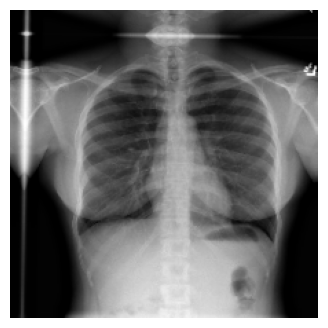

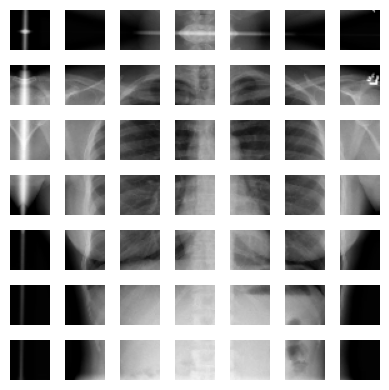

In [53]:
for image_batch, label_batch in train_generator:
    image = image_batch[0] 
    break 

image_size = 224
patch_size = 32  
num_patches = (image_size // patch_size) ** 2

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

image_tensor = tf.expand_dims(image, 0) 

patches_layer = Patches(patch_size)
patches = patches_layer(image_tensor)

patches_numpy = patches.numpy()
if np.max(patches_numpy) <= 1.0:
    patches_numpy *= 255  
patches_numpy = patches_numpy.astype('uint8') 

n = int(np.sqrt(num_patches))
plt.figure(figsize=(4, 4))
for i in range(n * n):
    ax = plt.subplot(n, n, i + 1)
    patch_img = patches_numpy[0, i].reshape(patch_size, patch_size, 3)
    plt.imshow(patch_img)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [54]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [55]:
num_patches = (image_size // patch_size) ** 2
projection_dim = 64

patch_encoder = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)

encoded_patches = patch_encoder(patches)

input_shape = (224, 224, 3)  
patch_size = 32             
num_patches = (224 // patch_size) ** 2  
projection_dim = 64          
num_heads = 4                
transformer_units = [
    projection_dim * 2,      
    projection_dim,
]
transformer_layers = 8       
mlp_head_units = [2048, 1024]  
num_classes = len(parser.labels)  
test_datagen = ImageDataGenerator(rescale=1./255)


In [56]:
def create_vit_classifier():
    inputs = Input(shape=input_shape)
    
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = Add()([attention_output, encoded_patches])
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = Add()([x3, x2])

    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = Flatten()(representation)
    representation = Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = Dense(num_classes, activation='sigmoid')(features)
    
    model = Model(inputs=inputs, outputs=logits)
    return model

In [57]:
batch_size = 32
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10 

In [58]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ]
    )

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=validation_generator,
        callbacks=[ModelCheckpoint(os.path.join("files", "model.keras"), monitor='val_loss', verbose=1, save_best_only=True)]
    )

    return history

In [59]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5045 - auc: 0.4950 - loss: 1.1431
Epoch 1: val_loss improved from inf to 0.40604, saving model to files/model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5109 - auc: 0.4943 - loss: 1.1259 - val_accuracy: 0.8704 - val_auc: 0.5825 - val_loss: 0.4060
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7083 - auc: 0.5918 - loss: 0.6686
Epoch 2: val_loss improved from 0.40604 to 0.33804, saving model to files/model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - accuracy: 0.7111 - auc: 0.5927 - loss: 0.6638 - val_accuracy: 0.8667 - val_auc: 0.6400 - val_loss: 0.3380
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7924 - auc: 0.5527 - loss: 0.5768
Epoch 3: val_loss did not improve from 0.33804
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step - accuracy: 0.8037 - auc: 0.5740 - loss: 0.5452 - val_accuracy: 0.8852 - val_auc: 0.6711 - val_loss: 0.3393
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - 

In [60]:
def plot_combined_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # plt.savefig('combined_historyV1.png')
    plt.show()

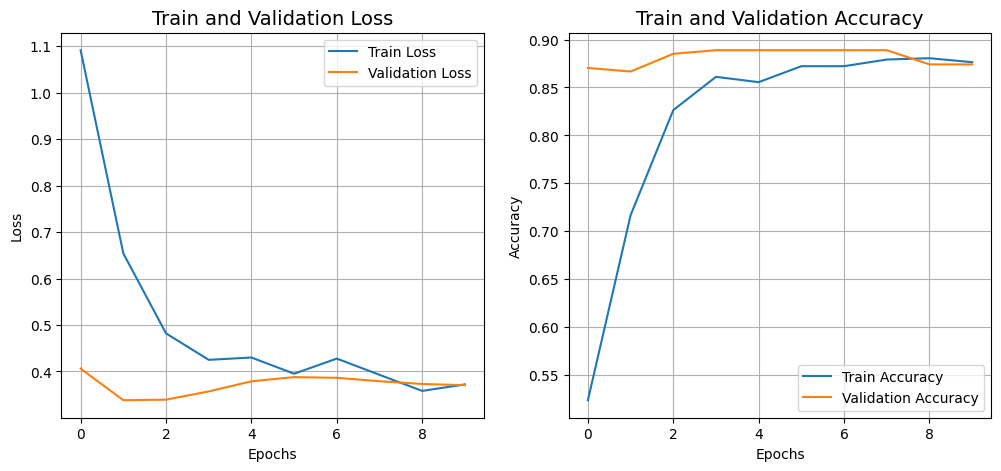

In [61]:
plot_combined_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
Test accuracy: 93.85%
Test AUC: 0.81
Test loss: 0.23
Shape of y_true: (13, 15)
Shape of predictions: (13, 15)


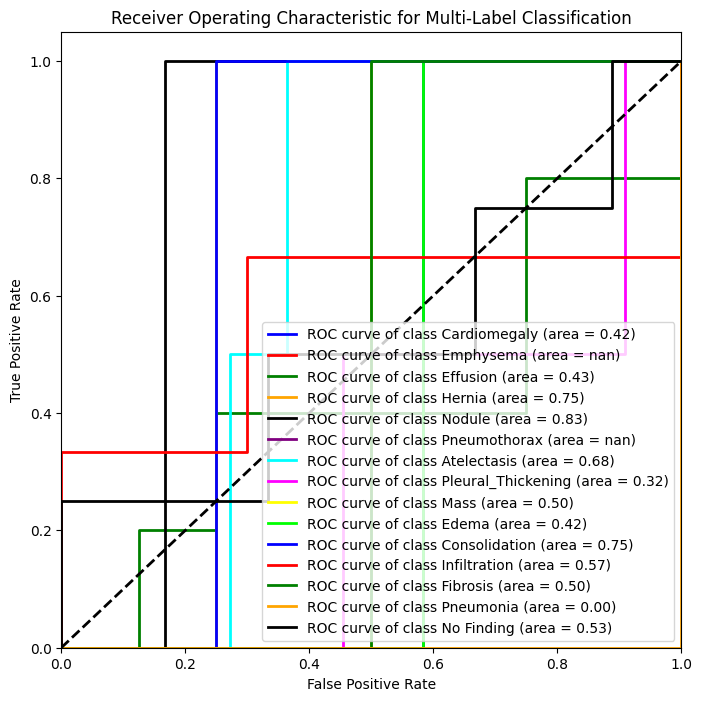

In [62]:
test_generator.reset()
steps = int(np.ceil(len(test_generator.filenames) / test_generator.batch_size))
predictions = vit_classifier.predict(test_generator, steps=steps, verbose=1)

loss, test_accuracy, test_auc = vit_classifier.evaluate(test_generator, steps=len(test_generator), verbose=0)

print("Test accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test AUC: {:.2f}".format(test_auc))
print("Test loss: {:.2f}".format(loss))

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple', 'cyan', 'magenta', 'yellow', 'lime'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Label Classification')
    plt.legend(loc="lower right")
    # plt.savefig("roc_curve.png")
    plt.show()

mlb = MultiLabelBinarizer(classes=parser.labels)
y_true = mlb.fit_transform(val['Label'])
if y_true.shape[0] > predictions.shape[0]:
    y_true = y_true[:predictions.shape[0], :]

print("Shape of y_true:", y_true.shape)
print("Shape of predictions:", predictions.shape)

plot_roc_curves(y_true, predictions, num_classes=len(parser.labels), class_labels=parser.labels)
